In [1]:
%%bash
ls ../../data/

20news_w100.mat
dr_sample
mnist.pkl.gz
mnist_cluttered_60x60_6distortions.npz
mnist_pretrained.pkl


Load the data

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import gzip
import cPickle as pickle

In [3]:
with gzip.open("../../data/mnist.pkl.gz") as f:
    dat = pickle.load(f)

In [4]:
train_data, _, _ = dat
X_train, y_train = train_data

In [6]:
X_train.dtype

dtype('float32')

In [95]:
# for cnn mode
X_train = X_train.reshape( (X_train.shape[0], 1, 28, 28) )

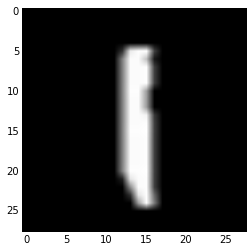

In [98]:
plt.imshow(X_train[1][0], cmap="gray")

In [45]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.init import *
from lasagne.objectives import *
import numpy as np
from lasagne.updates import *

Define the model architecture

In [13]:
def build_model():
    num_input = 28 * 28
    # should really use more dimensions, but this is nice for visualization
    num_code = 2
    num_hidden = 1000

    l_encoder_in = InputLayer((None, num_input), name='l_encoder_in')

    # first layer of the encoder/generator
    l_dense1 = DenseLayer(
        l_encoder_in, num_units=num_hidden, nonlinearity=rectify,
        name='l_encoder_dense1',
    )
    l_dense1.params[l_dense1.W].add('generator')
    l_dense1.params[l_dense1.b].add('generator')

    # second layer of the encoder/generator
    l_dense2 = DenseLayer(
        l_dense1, num_units=num_hidden, nonlinearity=rectify,
        name='l_encoder_dense2',
    )
    l_dense2.params[l_dense2.W].add('generator')
    l_dense2.params[l_dense2.b].add('generator')

    # output of the encoder/generator: q(z|x)
    l_encoder_out = DenseLayer(
        l_dense2, num_units=num_code, nonlinearity=linear,
        name='l_encoder_out',
    )
    l_encoder_out.params[l_encoder_out.W].add('generator')
    l_encoder_out.params[l_encoder_out.b].add('generator')

    # first layer of the decoder
    l_decoder_in = DenseLayer(
        l_encoder_out, num_units=num_hidden, nonlinearity=rectify,
        name='l_decoder_dense1',
    )
    # second layer of the decoder
    l_dense5 = DenseLayer(
        l_decoder_in, num_units=num_hidden, nonlinearity=rectify,
        name='l_decoder_dense2',
    )

    # output of the decoder: p(x|z)
    l_decoder_out = DenseLayer(
        l_dense5, num_units=num_input, nonlinearity=sigmoid,
        name='l_decoder_out',
    )

    # print output of encoder
    print "encoder/decoder:"
    for layer in get_all_layers(l_decoder_out):
        print layer, layer.name, layer.output_shape

    # --------------------------------------------------------------------------
        
    # input layer providing samples from p(z)
    l_prior = InputLayer((None, num_code), name='l_prior_in')

    # concatenate samples from q(z|x) to samples from p(z)
    l_concat = ConcatLayer(
        [l_encoder_out, l_prior], axis=0, name='l_prior_encoder_concat',
    )

    # first layer of the discriminator
    l_dense6 = DenseLayer(
        l_concat, num_units=num_hidden, nonlinearity=rectify,
        name='l_discriminator_dense1',
    )
    l_dense6.params[l_dense6.W].add('discriminator')
    l_dense6.params[l_dense6.b].add('discriminator')

    # second layer of the discriminator
    l_dense7 = DenseLayer(
        l_dense6, num_units=num_hidden, nonlinearity=rectify,
        name='l_discriminator_dense2',
    )
    l_dense7.params[l_dense7.W].add('discriminator')
    l_dense7.params[l_dense7.b].add('discriminator')

    # output layer of the discriminator
    l_discriminator_out = DenseLayer(
        l_dense7, num_units=1, nonlinearity=sigmoid,
        name='l_discriminator_out',
    )
    l_discriminator_out.params[l_discriminator_out.W].add('discriminator')
    l_discriminator_out.params[l_discriminator_out.b].add('discriminator')

    print "discriminator:"
    for layer in get_all_layers(l_discriminator_out):
        print layer, layer.name, layer.output_shape
        
    model_layers = get_all_layers([l_decoder_out, l_discriminator_out])

    # put all layers in a dictionary for convenience
    return {layer.name: layer for layer in model_layers}


In [123]:
def build_model_cnn():
    # should really use more dimensions, but this is nice for visualization
    num_code = 2
    num_hidden = 64

    l_encoder_in = InputLayer((None, 1, 28, 28), name='l_encoder_in')
    
    l_conv1 = Conv2DLayer(l_encoder_in, filter_size=3, num_filters=8, name="conv1")
    l_conv1.params[l_conv1.W].add("generator")
    l_conv1.params[l_conv1.b].add("generator")
                   
    l_mp1 = Pool2DLayer(l_conv1, pool_size=2, name="mp1", mode="average_inc_pad")
                   
    l_conv2 = Conv2DLayer(l_mp1, filter_size=3, num_filters=16, name="conv2")
    l_conv2.params[l_conv2.W].add("generator")
    l_conv2.params[l_conv2.b].add("generator")
                   
    l_mp2 = Pool2DLayer(l_conv2, pool_size=2, name="mp2", mode="average_inc_pad")
    
    # output of the encoder/generator: q(z|x)
    l_encoder_out = DenseLayer(l_mp2, num_units=num_code, nonlinearity=rectify, name="l_encoder_out")
    l_encoder_out.params[l_encoder_out.W].add('generator')
    l_encoder_out.params[l_encoder_out.b].add('generator')
        
    l_decoder_out = l_encoder_out
    k = 0
    for layer in get_all_layers(l_encoder_out)[::-1]:
        if isinstance(layer, InputLayer):
            break
        l_decoder_out = InverseLayer(l_decoder_out, layer, name="inv%i" % k)
        k += 1
    # output of the decoder: p(x|z)
    l_decoder_out.name = "l_decoder_out"
    l_decoder_out.nonlinearity = sigmoid

    # print output of encoder
    print "encoder/decoder:"
    for layer in get_all_layers(l_decoder_out):
        print layer, layer.name, layer.output_shape

    # --------------------------------------------------------------------------

    # input layer providing samples from p(z)
    l_prior = InputLayer((None, num_code), name='l_prior_in')

    # concatenate samples from q(z|x) to samples from p(z)
    l_concat = ConcatLayer(
        [l_encoder_out, l_prior], axis=0, name='l_prior_encoder_concat',
    )

    # first layer of the discriminator
    l_dense6 = DenseLayer(
        l_concat, num_units=num_hidden, nonlinearity=rectify,
        name='l_discriminator_dense1',
    )
    l_dense6.params[l_dense6.W].add('discriminator')
    l_dense6.params[l_dense6.b].add('discriminator')

    # second layer of the discriminator
    l_dense7 = DenseLayer(
        l_dense6, num_units=num_hidden, nonlinearity=rectify,
        name='l_discriminator_dense2',
    )
    l_dense7.params[l_dense7.W].add('discriminator')
    l_dense7.params[l_dense7.b].add('discriminator')

    # output layer of the discriminator
    l_discriminator_out = DenseLayer(
        l_dense7, num_units=1, nonlinearity=sigmoid,
        name='l_discriminator_out',
    )
    l_discriminator_out.params[l_discriminator_out.W].add('discriminator')
    l_discriminator_out.params[l_discriminator_out.b].add('discriminator')

    print "discriminator:"
    for layer in get_all_layers(l_discriminator_out):
        print layer, layer.name, layer.output_shape
        
    model_layers = get_all_layers([l_decoder_out, l_discriminator_out])

    # put all layers in a dictionary for convenience
    return {layer.name: layer for layer in model_layers}
    



In [14]:
model_dict = build_model()

encoder/decoder:
<lasagne.layers.input.InputLayer object at 0x103cc8110> l_encoder_in (None, 784)
<lasagne.layers.dense.DenseLayer object at 0x10c437790> l_encoder_dense1 (None, 1000)
<lasagne.layers.dense.DenseLayer object at 0x10c4d4090> l_encoder_dense2 (None, 1000)
<lasagne.layers.dense.DenseLayer object at 0x10c4b0610> l_encoder_out (None, 2)
<lasagne.layers.dense.DenseLayer object at 0x10c4b0850> l_decoder_dense1 (None, 1000)
<lasagne.layers.dense.DenseLayer object at 0x10c4b0a90> l_decoder_dense2 (None, 1000)
<lasagne.layers.dense.DenseLayer object at 0x10c4b0cd0> l_decoder_out (None, 784)
discriminator:
<lasagne.layers.input.InputLayer object at 0x103cc8110> l_encoder_in (None, 784)
<lasagne.layers.dense.DenseLayer object at 0x10c437790> l_encoder_dense1 (None, 1000)
<lasagne.layers.dense.DenseLayer object at 0x10c4d4090> l_encoder_dense2 (None, 1000)
<lasagne.layers.dense.DenseLayer object at 0x10c4b0610> l_encoder_out (None, 2)
<lasagne.layers.input.InputLayer object at 0x10c

In [124]:
cnn_model_dict = build_model_cnn()

encoder/decoder:
<lasagne.layers.input.InputLayer object at 0x1165e7750> l_encoder_in (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x1165e7850> conv1 (None, 8, 26, 26)
<lasagne.layers.pool.Pool2DLayer object at 0x1165e7ad0> mp1 (None, 8, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x1165e7a10> conv2 (None, 16, 11, 11)
<lasagne.layers.pool.Pool2DLayer object at 0x1165e7d10> mp2 (None, 16, 5, 5)
<lasagne.layers.dense.DenseLayer object at 0x1165e7e50> l_encoder_out (None, 2)
<lasagne.layers.special.InverseLayer object at 0x1165e7150> inv0 (None, 16, 5, 5)
<lasagne.layers.special.InverseLayer object at 0x1165e7210> inv1 (None, 16, 11, 11)
<lasagne.layers.special.InverseLayer object at 0x1165e7250> inv2 (None, 8, 13, 13)
<lasagne.layers.special.InverseLayer object at 0x1165e7290> inv3 (None, 8, 26, 26)
<lasagne.layers.special.InverseLayer object at 0x1165e7090> l_decoder_out (None, 1, 28, 28)
discriminator:
<lasagne.layers.input.InputLayer object at 0x1165e7750> l_enc

In [72]:
model_dict

{'l_decoder_dense1': <lasagne.layers.dense.DenseLayer at 0x10c4b0850>,
 'l_decoder_dense2': <lasagne.layers.dense.DenseLayer at 0x10c4b0a90>,
 'l_decoder_out': <lasagne.layers.dense.DenseLayer at 0x10c4b0cd0>,
 'l_discriminator_dense1': <lasagne.layers.dense.DenseLayer at 0x10c4c3110>,
 'l_discriminator_dense2': <lasagne.layers.dense.DenseLayer at 0x10c4c3310>,
 'l_discriminator_out': <lasagne.layers.dense.DenseLayer at 0x10c4c35d0>,
 'l_encoder_dense1': <lasagne.layers.dense.DenseLayer at 0x10c437790>,
 'l_encoder_dense2': <lasagne.layers.dense.DenseLayer at 0x10c4d4090>,
 'l_encoder_in': <lasagne.layers.input.InputLayer at 0x103cc8110>,
 'l_encoder_out': <lasagne.layers.dense.DenseLayer at 0x10c4b0610>,
 'l_prior_encoder_concat': <lasagne.layers.merge.ConcatLayer at 0x10c4c30d0>,
 'l_prior_in': <lasagne.layers.input.InputLayer at 0x10c4b0f10>}

Create functions

In [125]:
# forward pass for the encoder, q(z|x)
def create_encoder_func(layers):
    X = T.tensor4('X')
    X_batch = T.tensor4('X_batch')

    Z = get_output(layers['l_encoder_out'], X, deterministic=True)
    
    encoder_func = theano.function(
        inputs=[theano.In(X_batch)],
        outputs=Z,
        givens={
            X: X_batch,
        },
    )
    
    return encoder_func


In [126]:
encoder_func = create_encoder_func(cnn_model_dict)

In [130]:
encoder_func(X_train[0:1])

array([[ 0.00901434,  0.        ]])

In [145]:
for layer in get_all_layers(cnn_model_dict["l_decoder_out"]):
    print layer, layer.name, layer.output_shape

<lasagne.layers.input.InputLayer object at 0x1165e7750> l_encoder_in (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x1165e7850> conv1 (None, 8, 26, 26)
<lasagne.layers.pool.Pool2DLayer object at 0x1165e7ad0> mp1 (None, 8, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x1165e7a10> conv2 (None, 16, 11, 11)
<lasagne.layers.pool.Pool2DLayer object at 0x1165e7d10> mp2 (None, 16, 5, 5)
<lasagne.layers.dense.DenseLayer object at 0x1165e7e50> l_encoder_out (None, 2)
<lasagne.layers.special.InverseLayer object at 0x1165e7150> inv0 (None, 16, 5, 5)
<lasagne.layers.special.InverseLayer object at 0x1165e7210> inv1 (None, 16, 11, 11)
<lasagne.layers.special.InverseLayer object at 0x1165e7250> inv2 (None, 8, 13, 13)
<lasagne.layers.special.InverseLayer object at 0x1165e7290> inv3 (None, 8, 26, 26)
<lasagne.layers.special.InverseLayer object at 0x1165e7090> l_decoder_out (None, 1, 28, 28)


In [131]:
# forward pass for the decoder, p(x|z)
def create_decoder_func(layers):
    Z = T.fmatrix('Z')
    Z_batch = T.fmatrix('Z_batch')

    X = get_output(
        layers['l_decoder_out'],
        inputs={
            layers['l_encoder_out']: Z
        },
        deterministic=True
    )

    decoder_func = theano.function(
        inputs=[theano.In(Z_batch)],
        outputs=X,
        givens={
            Z: Z_batch,
        },
    )

    return decoder_func

In [136]:
decoder_func = create_decoder_func(cnn_model_dict)

DisconnectedInputError: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='average_inc_pad'}.0
Backtrace when the node is created:
  File "//anaconda/lib/python2.7/site-packages/Lasagne-0.2.dev1-py2.7.egg/lasagne/layers/pool.py", line 267, in get_output_for
    mode=self.mode,


In [24]:
decoder_func(
    encoder_func(X_train[0:1]).astype("float32")
).shape

(1, 784)

In [21]:
X_train.shape

(50000, 784)

In [151]:
# forward/backward (optional) pass for the encoder/decoder pair
def create_encoder_decoder_func(layers, apply_updates=False):
    X = T.tensor4('X')
    X_batch = T.tensor4('X_batch')

    X_hat = get_output(layers['l_decoder_out'], X, deterministic=False)

    # reconstruction loss
    encoder_decoder_loss = T.mean(
        T.mean(T.sqr(X - X_hat), axis=1)
    )

    if apply_updates:
        # all layers that participate in the forward pass should be updated
        encoder_decoder_params = get_all_params(
            layers['l_decoder_out'], trainable=True)

        encoder_decoder_updates = nesterov_momentum(
            encoder_decoder_loss, encoder_decoder_params, 0.01, 0.9)
    else:
        encoder_decoder_updates = None

    encoder_decoder_func = theano.function(
        inputs=[theano.In(X_batch)],
        outputs=encoder_decoder_loss,
        updates=encoder_decoder_updates,
        givens={
            X: X_batch,
        },
    )

    return encoder_decoder_func

In [152]:
create_encoder_decoder_func(cnn_model_dict)

In [155]:
# forward/backward (optional) pass for discriminator
def create_discriminator_func(layers, apply_updates=False):
    X = T.tensor4('X')
    pz = T.fmatrix('pz')

    X_batch = T.tensor4('X_batch')
    pz_batch = T.fmatrix('pz_batch')

    # the discriminator receives samples from q(z|x) and p(z)
    # and should predict to which distribution each sample belongs
    discriminator_outputs = get_output(
        layers['l_discriminator_out'],
        inputs={
            layers['l_prior_in']: pz,
            layers['l_encoder_in']: X,
        },
        deterministic=False,
    )

    # label samples from q(z|x) as 1 and samples from p(z) as 0
    discriminator_targets = T.vertical_stack(
        T.ones((X_batch.shape[0], 1)),
        T.zeros((pz_batch.shape[0], 1))
    )

    discriminator_loss = T.mean(
        T.nnet.binary_crossentropy(
            discriminator_outputs,
            discriminator_targets,
        )
    )

    if apply_updates:
        # only layers that are part of the discriminator should be updated
        discriminator_params = get_all_params(
            layers['l_discriminator_out'], trainable=True, discriminator=True)

        discriminator_updates = nesterov_momentum(
            discriminator_loss, discriminator_params, 0.1, 0.0)
    else:
        discriminator_updates = None

    discriminator_func = theano.function(
        inputs=[
            theano.In(X_batch),
            theano.In(pz_batch),
        ],
        outputs=discriminator_loss,
        updates=discriminator_updates,
        givens={
            X: X_batch,
            pz: pz_batch,
        },
    )

    return discriminator_func


In [156]:
discriminator_func = create_discriminator_func(model_dict)

In [31]:
pz_train_batch = np.random.uniform(
    low=-2, high=2,
    size=(X_train.shape[0], 2)).astype(np.float32)
discriminator_func(X_train[0:1], pz_train_batch[0:1])

array(0.675344140239736)

In [33]:
# forward/backward (optional) pass for the generator
# note that the generator is the same network as the encoder,
# but updated separately
def create_generator_func(layers, apply_updates=False):
    X = T.fmatrix('X')
    X_batch = T.fmatrix('X_batch')

    # no need to pass an input to l_prior_in here
    generator_outputs = get_output(
        layers['l_encoder_out'], X, deterministic=False)

    # so pass the output of the generator as the output of the concat layer
    discriminator_outputs = get_output(
        layers['l_discriminator_out'],
        inputs={
            layers['l_prior_encoder_concat']: generator_outputs,
        },
        deterministic=False
    )

    # the discriminator learns to predict 1 for q(z|x),
    # so the generator should fool it into predicting 0
    generator_targets = T.zeros_like(X_batch.shape[0])

    # so the generator needs to push the discriminator's output to 0
    generator_loss = T.mean(
        T.nnet.binary_crossentropy(
            discriminator_outputs,
            generator_targets,
        )
    )

    if apply_updates:
        # only layers that are part of the generator (i.e., encoder)
        # should be updated
        generator_params = get_all_params(
            layers['l_discriminator_out'], trainable=True, generator=True)

        generator_updates = nesterov_momentum(
            generator_loss, generator_params, 0.1, 0.0)
    else:
        generator_updates = None

    generator_func = theano.function(
        inputs=[
            theano.In(X_batch),
        ],
        outputs=generator_loss,
        updates=generator_updates,
        givens={
            X: X_batch,
        },
    )

    return generator_func


In [35]:
generator_func = create_generator_func(model_dict)

In [36]:
generator_func(X_train[0:1])

array(0.691995816875417)

In [47]:
print('compiling theano functions for training')
print('  encoder/decoder')
encoder_decoder_update = create_encoder_decoder_func(
    model_dict, apply_updates=True)
print('  discriminator')
discriminator_update = create_discriminator_func(
    model_dict, apply_updates=True)
print('  generator')
generator_update = create_generator_func(
    model_dict, apply_updates=True)

compiling theano functions for training
  encoder/decoder
  discriminator
  generator


In [40]:
def iterator(X_train, bs=32):
    b = 0
    while True:
        if b*bs >= X_train.shape[0]:
            break
        yield X_train[b*bs:(b+1)*bs]
        b += 1

In [48]:
max_epochs=10
idxs = [x for x in range(0, X_train.shape[0])]
for epoch in range(1, max_epochs+1):
    
    print('epoch %d' % (epoch))
    
    # compute loss on training data and apply gradient updates
    train_reconstruction_losses = []
    train_discriminative_losses = []
    train_generative_losses = []
    
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    
    for X_train_batch in iterator(X_train, bs=32):

        # 1.) update the encoder/decoder to min. reconstruction loss
        train_batch_reconstruction_loss =\
            encoder_decoder_update(X_train_batch)

        # sample from p(z)
        pz_train_batch = np.random.uniform(
            low=-2, high=2,
            size=(X_train_batch.shape[0], 2)).astype(
                np.float32)

        # 2.) update discriminator to separate q(z|x) from p(z)
        train_batch_discriminative_loss =\
            discriminator_update(X_train_batch, pz_train_batch)

        # 3.)  update generator to output q(z|x) that mimic p(z)
        train_batch_generative_loss = generator_update(X_train_batch)

        train_reconstruction_losses.append(
            train_batch_reconstruction_loss)
        train_discriminative_losses.append(
            train_batch_discriminative_loss)
        train_generative_losses.append(
            train_batch_generative_loss)

    # average over minibatches
    train_reconstruction_losses_mean = np.mean(
        train_reconstruction_losses)
    train_discriminative_losses_mean = np.mean(
        train_discriminative_losses)
    train_generative_losses_mean = np.mean(
        train_generative_losses)

    print('  train: rec = %.6f, dis = %.6f, gen = %.6f' % (
        train_reconstruction_losses_mean,
        train_discriminative_losses_mean,
        train_generative_losses_mean,
    ))


epoch 1
  train: rec = 0.212946, dis = 0.686736, gen = 0.740064
epoch 2
  train: rec = 0.097661, dis = 0.689868, gen = 0.717792
epoch 3
  train: rec = 0.067434, dis = 0.693079, gen = 0.695199
epoch 4
  train: rec = 0.064287, dis = 0.693110, gen = 0.693812
epoch 5
  train: rec = 0.061969, dis = 0.693119, gen = 0.693759
epoch 6
  train: rec = 0.060150, dis = 0.693200, gen = 0.693867
epoch 7
  train: rec = 0.058863, dis = 0.693235, gen = 0.693560
epoch 8
  train: rec = 0.058029, dis = 0.693222, gen = 0.693571
epoch 9
  train: rec = 0.057446, dis = 0.693196, gen = 0.693570
epoch 10
  train: rec = 0.057029, dis = 0.693202, gen = 0.693407


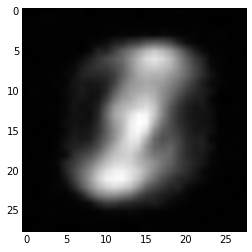

In [61]:
plt.imshow( decoder_func( encoder_func(X_train[2:3]).astype("float32") ).reshape((28,28)), cmap="gray" )

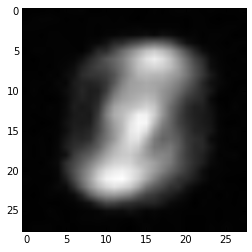

In [71]:
plt.imshow( decoder_func( np.random.uniform(low=-2, high=2, size=(1, 2)).astype(np.float32) ).reshape((28,28)), cmap="gray" )